
#  fraud detection system


For the sake of simplicity, this section will not address the validation part of the baseline supervised learning methodology. The design of our fraud detection system will consist of three main steps,


1. Defining a training set (historical data) and a test set (new data). The training set is the subset of transactions that are used for training the prediction model. The test set is the subset of transactions that are used to assess the performance of the prediction model.
2. Training a prediction model: This step consists in using the training set to find a prediction model able to predict whether a transaction is genuine or fraudulent. We will rely for this task on the Python `sklearn` library, which provides easy-to-use functions to train prediction models. 
3. Assessing the performance of the prediction model: The performance of the prediction model is assessed using the test set (new data). 




## Defining the training and test sets

The training set aims at training a prediction model, while the test set aims at evaluating the performance of the prediction model on new data. In a fraud detection context, the transactions of the test set occur chronologically *after* the transactions used for training the model. 

We will use the transactions from the 2018-07-25 to the 2018-07-31 for the training set, and from the 2018-08-08 to the 2018-08-14 for the test set. One week of data will be sufficient to train a first prediction model and to assess its performance. We will later use larger periods for training and testing to evaluate how larger sets can affect the performance results.

It is worth noting that we choose our test set to take place one week after the last transaction of the training set. In a fraud detection context, this period separating the training and test set is referred to as the *delay period* or *feedback delay*. It accounts for the fact that, in a real-world fraud detection system, the label of a transaction (fraudulent or genuine) is only known after a customer complaint, or thanks to the result of a fraud investigation. Therefore, in a realistic scenario, the annotated data available to train a model and start making predictions for a given day are anterior to that day minus the delay period. Setting a delay period of one week is simplistic. It assumes that the labels (fraudulent or genuine) for all transactions are known exactly one week after they occurred. This is not the case in practice, since the delay may be shorter when customers report frauds quickly, or much longer in cases where frauds remain undetected for months. The delay period is in fact a parameter in the assessment of a fraud detection model, which can be tuned during the validation stage.(Validation_Strategies)). A one-week delay is, to a first approximation, a reasonable basis: from experience, statistics generally show that most of the feedback becomes available after a one week delay.   

Let us load the transactions from the 2018-07-25 to the 2018-08-14, and plot the number of transactions per day, fraudulent transactions per day, and fraudulent cards per day.


In [48]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
%run shared_functions.py

<Figure size 640x480 with 0 Axes>

In [49]:
import pandas as pd
import os

DIR_INPUT = '../data/processed/transaction/'
BEGIN_DATE = "2024-06-01"
END_DATE = "2024-12-31"

# Load all files from the directory into a DataFrame
print("Loading files...")
all_files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f.endswith('.pkl')]

# Concatenate all CSV files into a single DataFrame
transactions_df = pd.concat((pd.read_pickle(f) for f in all_files), ignore_index=True)

# Convert the TX_DATETIME column to datetime type (assuming it exists in your dataset)
transactions_df['TX_DATETIME'] = pd.to_datetime(transactions_df['TX_DATETIME'])

# Filter transactions by the date range
transactions_df = transactions_df[
    (transactions_df['TX_DATETIME'] >= BEGIN_DATE) & (transactions_df['TX_DATETIME'] <= END_DATE)
]

# Print the transaction statistics
print(f"{len(transactions_df)} transactions loaded, containing {transactions_df['TX_FRAUD'].sum()} fraudulent transactions.")


Loading files...
2041821 transactions loaded, containing 17188 fraudulent transactions.


In [50]:
# Compute the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_tx_stats(transactions_df, start_date_df=BEGIN_DATE):
    
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraudulent_transactions_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of compromised cards per day
    nb_compromised_cards_per_day=transactions_df[transactions_df['TX_FRAUD']==1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    tx_stats=pd.DataFrame({"nb_tx_per_day":nb_tx_per_day,
                           "nb_fraudulent_transactions_per_day":nb_fraudulent_transactions_per_day,
                           "nb_compromised_cards_per_day":nb_compromised_cards_per_day})

    tx_stats=tx_stats.reset_index()
    
    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)
    
    tx_stats['tx_date']=tx_date
    
    return tx_stats

tx_stats=get_tx_stats(transactions_df, start_date_df=BEGIN_DATE)


In [51]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_template_tx_stats(ax ,fs,
                          start_date_training,
                          title='',
                          delta_train=153,
                          delta_delay=30,
                          delta_test=30,
                          ylim=300):
    
    ax.set_title(title, fontsize=fs*1.5)
    ax.set_ylim([0, ylim])
    
    ax.set_xlabel('Date', fontsize=fs)
    ax.set_ylabel('Number', fontsize=fs)
    
    plt.yticks(fontsize=fs*0.7) 
    plt.xticks(fontsize=fs*0.7)    

    ax.axvline(start_date_training+datetime.timedelta(days=delta_train), 0,ylim, color="black")
    ax.axvline(start_date_test, 0, ylim, color="black")
    
    ax.text(start_date_training+datetime.timedelta(days=2), ylim-20,'Training period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+2), ylim-20,'Delay period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+delta_delay+2), ylim-20,'Test period', fontsize=fs)


cmap = plt.get_cmap('jet')
colors={'nb_tx_per_day':cmap(0), 
        'nb_fraudulent_transactions_per_day':cmap(200), 
        'nb_compromised_cards_per_day':cmap(250)}

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
delta_train =153
delta_delay =30
delta_test = 30

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Total transactions, and number of fraudulent transactions \n and number of compromised cards per day',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
ax.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day'], 'b', color=colors['nb_compromised_cards_per_day'], label = '# compromised cards per day')

ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)



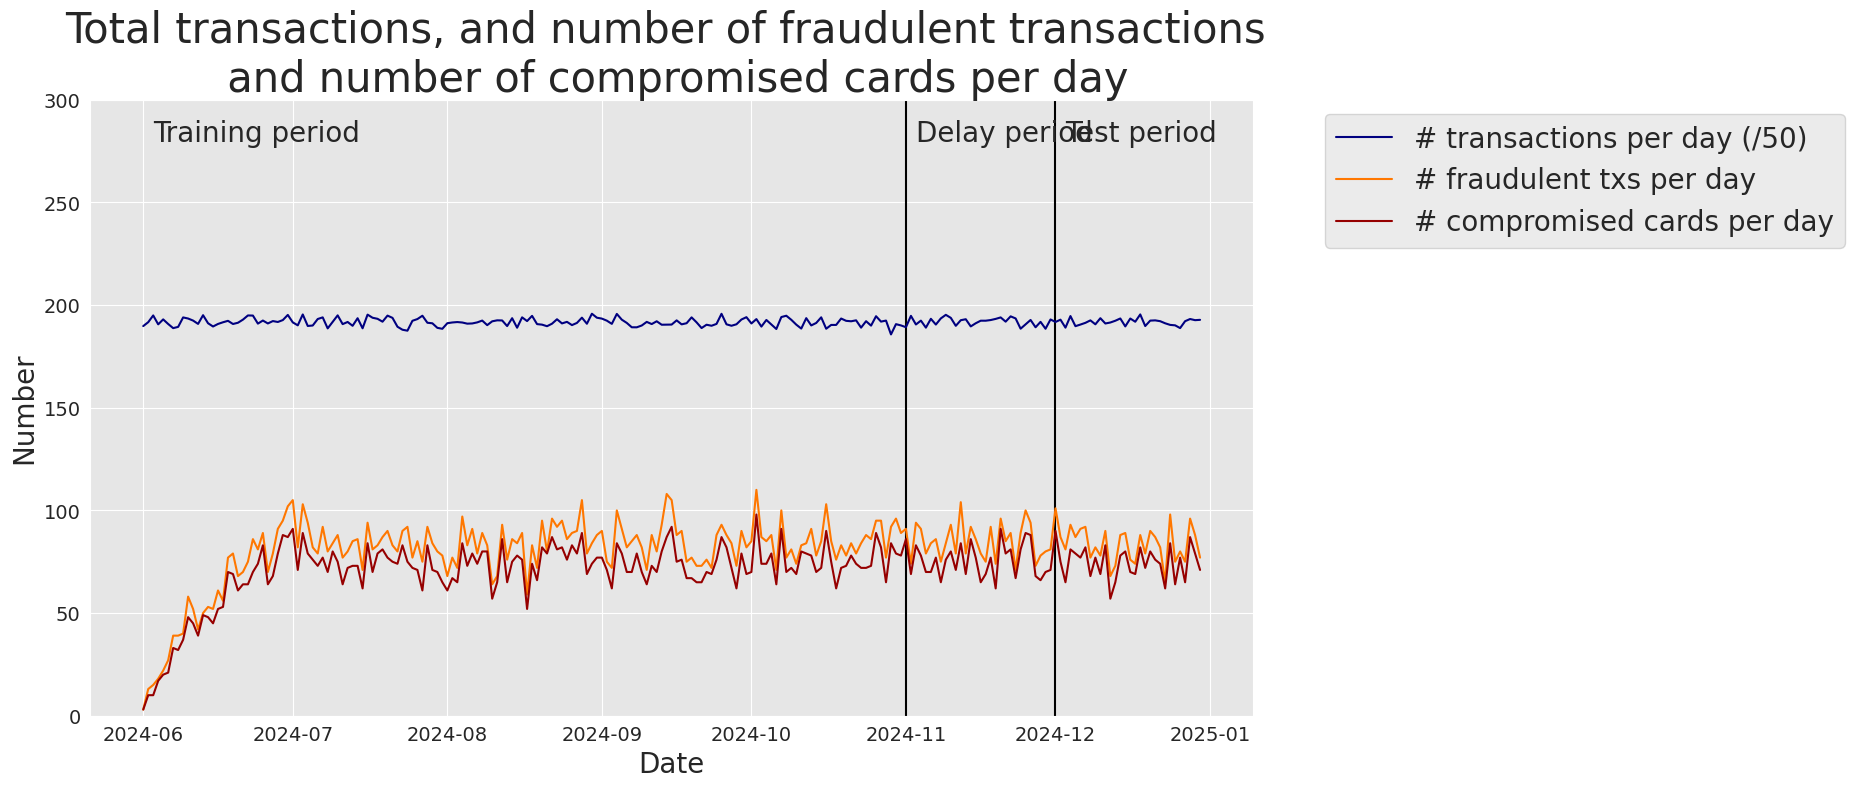

In [52]:
fraud_and_transactions_stats_fig

The plot illustrates that the number of transactions and frauds is similar in the training and test periods. The average number of frauds is around 85 per day. Let us extract from the dataset the transactions for the training set and the test set. 

In [53]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=153,delta_delay=30,delta_test=30):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

In [54]:
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=153,delta_delay=30,delta_test=30)

The trainig set contains 1466282 transactions, among which 12134 are fraudulent.

In [55]:
train_df.shape

(1466282, 23)

In [56]:
train_df[train_df.TX_FRAUD==1].shape


(12134, 23)

The test set contains 66452 transactions, among which 583 are fraudulent.

In [57]:
test_df.shape

(66452, 23)

In [58]:
test_df[test_df.TX_FRAUD==1].shape


(583, 23)

That is, a proportion of 0.008 fraudulent transactions.

In [59]:
583/66452

0.008773249864563896


## Model training : Decision tree
 The training of a prediction model consists in identifying a mathematical relationship between two sets of features, called *input* and *output* features. In a fraud detection context, the goal is to find a function that can predict whether a transaction is fraudulent or genuine (the output feature), using features that characterize the transactions (the input features).

We will define the input and output features as follows:

* The output feature will be the transaction label `TX_FRAUD`
* The input features will be the transaction amount `TX_AMOUNT`, as well as all the features that were computed in the previous section, which characterize the context of a transaction.


In [60]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


In Python, the training of a prediction model is made easy using the `sklearn` library. In particular, the  `sklearn`  library provides implementations for training a wide range of prediction models.  



We will start by relying on a prediction model called a *decision tree*.

Let us create a function `fit_model_and_get_predictions` that trains a model and returns predictions for a test set. The function takes as input a `sklearn` classifier object (a `sklearn` prediction model), a training set, a test set, and the set of input and output features. The training set will be used to train the classifier. This is done by calling the `fit` method of the `sklearn` classifier object. The predictions of the classifier for the training and test sets are then obtained by calling the `predict_proba` method of the `sklearn` classifier object.

The function returns a dictionary that contains the trained classifier, the predictions for the training set, the predictions for the test set, and the execution times for training and inference.

In [61]:
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                  input_features, output_feature="TX_FRAUD",scale=True):

    # By default, scales input data
    if scale:
        (train_df, test_df, scaler)=scaleData(train_df,test_df,input_features)
    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

As an example, let us train a small decision tree (with a maximum depth of 2). We first create a decision tree object (`sklearn.tree.DecisionTreeClassifier`), and call the `fit_model_and_get_predictions_dictionary` to train the decision tree, and get the predictions on the training and test sets. 

In [62]:
train_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
670811,0,2024-06-01 00:00:31,596,3156,57.16,31,0,0,0,1,...,1.0,57.16,1.0,57.16,0.0,0.0,0.0,0.0,0.0,0.0
670812,1,2024-06-01 00:02:10,4961,3412,81.51,130,0,0,0,1,...,1.0,81.51,1.0,81.51,0.0,0.0,0.0,0.0,0.0,0.0
670813,2,2024-06-01 00:07:56,2,1365,146.00,476,0,0,0,1,...,1.0,146.00,1.0,146.00,0.0,0.0,0.0,0.0,0.0,0.0
670814,3,2024-06-01 00:09:29,4128,8737,64.49,569,0,0,0,1,...,1.0,64.49,1.0,64.49,0.0,0.0,0.0,0.0,0.0,0.0
670815,4,2024-06-01 00:10:34,927,9906,50.99,634,0,0,0,1,...,1.0,50.99,1.0,50.99,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
train_df.dtypes

TRANSACTION_ID                                  int64
TX_DATETIME                            datetime64[ns]
CUSTOMER_ID                                     int64
TERMINAL_ID                                     int64
TX_AMOUNT                                     float64
TX_TIME_SECONDS                                 int64
TX_TIME_DAYS                                    int64
TX_FRAUD                                        int64
TX_FRAUD_SCENARIO                               int64
TX_DURING_WEEKEND                               int64
TX_DURING_NIGHT                                 int64
CUSTOMER_ID_NB_TX_1DAY_WINDOW                 float64
CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW            float64
CUSTOMER_ID_NB_TX_7DAY_WINDOW                 float64
CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW            float64
CUSTOMER_ID_NB_TX_30DAY_WINDOW                float64
CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW           float64
TERMINAL_ID_NB_TX_1DAY_WINDOW                 float64
TERMINAL_ID_RISK_1DAY_WINDOW

In [43]:
(scaled_train_df, scaled_test_df, scaler)=scaleData(train_df,test_df,input_features)
    

In [45]:
scaled_train_df[input_features].head()

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
670811,0.083531,1.571756,2.179923,-1.385706,0.100736,-2.221993,0.116327,-2.131788,0.121613,-0.934021,-0.074134,-1.948957,-0.10976,-2.180602,-0.131793
670812,0.660578,1.571756,2.179923,-1.385706,0.796652,-2.221993,0.915917,-2.131788,0.951770,-0.934021,-0.074134,-1.948957,-0.10976,-2.180602,-0.131793
670813,2.188865,1.571756,2.179923,-1.385706,2.639756,-2.221993,3.033599,-2.131788,3.150407,-0.934021,-0.074134,-1.948957,-0.10976,-2.180602,-0.131793
670814,0.257238,1.571756,2.179923,-1.385706,0.310225,-2.221993,0.357025,-2.131788,0.371512,-0.934021,-0.074134,-1.948957,-0.10976,-2.180602,-0.131793
670815,-0.062686,1.571756,2.179923,-1.385706,-0.075600,-2.221993,-0.086279,-2.131788,-0.088739,-0.934021,-0.074134,-1.948957,-0.10976,-2.180602,-0.131793


In [47]:
train_df[input_features].head()

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
670811,0.083531,1.571756,2.179923,-1.385706,0.100736,-2.221993,0.116327,-2.131788,0.121613,-0.934021,-0.074134,-1.948957,-0.10976,-2.180602,-0.131793
670812,0.660578,1.571756,2.179923,-1.385706,0.796652,-2.221993,0.915917,-2.131788,0.951770,-0.934021,-0.074134,-1.948957,-0.10976,-2.180602,-0.131793
670813,2.188865,1.571756,2.179923,-1.385706,2.639756,-2.221993,3.033599,-2.131788,3.150407,-0.934021,-0.074134,-1.948957,-0.10976,-2.180602,-0.131793
670814,0.257238,1.571756,2.179923,-1.385706,0.310225,-2.221993,0.357025,-2.131788,0.371512,-0.934021,-0.074134,-1.948957,-0.10976,-2.180602,-0.131793
670815,-0.062686,1.571756,2.179923,-1.385706,-0.075600,-2.221993,-0.086279,-2.131788,-0.088739,-0.934021,-0.074134,-1.948957,-0.10976,-2.180602,-0.131793


In [27]:
import joblib

In [28]:
joblib.dump(scaler, '../data/scaler.pkl')

['../data/scaler.pkl']

In [ ]:
train_df

In [16]:
# We first create a decision tree object. We will limit its depth to 2 for interpretability, 
# and set the random state to zero for reproducibility
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=False)

In [17]:
test_df.describe()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
count,6.645200e+04,66452,66452.000000,66452.000000,66452.000000,6.645200e+04,66452.000000,66452.000000,66452.000000,66452.000000,...,66452.000000,66452.000000,66452.000000,66452.000000,66452.000000,66452.000000,66452.000000,66452.000000,66452.000000,66452.000000
mean,1.890936e+06,2024-12-15 06:23:35.652109568,2572.239060,4999.403269,49.298750,1.704382e+07,196.765876,0.008773,0.020014,0.299208,...,16.508999,49.271440,67.517772,49.189213,0.993243,0.005492,6.941702,0.008923,29.768720,0.008145
min,1.754155e+06,2024-12-01 00:00:13,3.000000,0.000000,0.000000,1.581121e+07,183.000000,0.000000,0.000000,0.000000,...,1.000000,0.230000,1.000000,2.620000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,1.818411e+06,2024-12-07 14:59:56.750000128,1348.000000,2539.000000,19.100000,1.638360e+07,189.000000,0.000000,0.000000,0.000000,...,10.000000,24.899687,41.000000,25.433799,0.000000,0.000000,5.000000,0.000000,24.000000,0.000000
50%,1.887440e+06,2024-12-14 18:45:20,2667.000000,4994.000000,40.560000,1.700192e+07,196.000000,0.000000,0.000000,0.000000,...,16.000000,47.891667,68.000000,48.049191,1.000000,0.000000,7.000000,0.000000,29.000000,0.000000
75%,1.961470e+06,2024-12-22 13:29:40.249999872,3817.000000,7479.000000,70.710000,1.767418e+07,204.000000,0.000000,0.000000,1.000000,...,23.000000,70.454053,96.000000,71.095153,2.000000,0.000000,9.000000,0.000000,35.000000,0.000000
max,2.041820e+06,2024-12-30 23:59:24,4999.000000,9999.000000,703.100000,1.840316e+07,212.000000,1.000000,3.000000,1.000000,...,53.000000,376.050000,153.000000,236.085000,9.000000,1.000000,25.000000,1.000000,76.000000,1.000000
std,8.284619e+04,NaN,1441.592252,2881.184328,39.042505,7.461424e+05,8.633530,0.093255,0.218116,0.457915,...,8.407014,28.757631,32.661317,27.351159,1.013728,0.070864,3.030184,0.077241,8.474092,0.059768


Let us look at the predictions obtained for the first five transactions of the test set:

In [18]:
test_df['TX_FRAUD_PREDICTED']=model_and_predictions_dictionary['predictions_test']
test_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED
2041743,1754155,2024-12-01 00:00:13,720,9918,80.30,15811213,183,0,0,1,...,96.174444,104.0,96.470288,2.0,0.0,7.0,0.0,44.0,0.045455,0.003377
2041745,1754157,2024-12-01 00:00:34,4736,5345,32.89,15811234,183,0,0,1,...,50.051250,118.0,51.418051,2.0,0.0,9.0,0.0,27.0,0.000000,0.003377
2041750,1754162,2024-12-01 00:03:31,4729,2351,70.18,15811411,183,0,0,1,...,68.479259,95.0,67.503789,3.0,0.0,8.0,0.0,38.0,0.000000,0.003377
2041753,1754165,2024-12-01 00:07:06,4355,576,27.43,15811626,183,0,0,1,...,53.393125,83.0,30.757229,1.0,0.0,4.0,0.0,18.0,0.000000,0.003377
2041756,1754168,2024-12-01 00:09:47,20,1488,17.64,15811787,183,0,0,1,...,11.165000,62.0,12.668065,0.0,0.0,10.0,0.0,35.0,0.000000,0.003377


The probability of fraud for all these transactions is of 0.003377. We can display the decision tree to understand how these probabilities were set:

In [19]:
from sklearn.tree import export_graphviz
from graphviz import Source
display(graphviz.Source(sklearn.tree.export_graphviz\
        (classifier,feature_names=input_features,\
         class_names=True, filled=True)))

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

A decision tree allows splitting the input space into different regions, in such a way that the fraudulent transactions are separated from the genuine transactions. The last level of the tree (the leaves) gives the number of fraudulent and genuine training transactions in each of these regions. The color indicates whether a node or leaf of the tree contains a majority of genuine (orange) or fraudulent (blue) transactions.

Each of the five first transactions falls into the first leaf, a region that contains 236 fraudulent transactions and 66498 genuine transactions, that is, a region where the probability of fraud is $\frac{236}{66498+236}=0.003536$.

It is worth noting that the decision tree correctly found that transactions with a high amount are frauds (scenario 1 in the [fraud generation process](Fraud_Scenarios_Generation)). The corresponding region is the second leaf. The decision threshold (218.67) is however not optimally found, as the second leaf contains 2 misclassified genuine transactions. The optimal threshold should be 220, as defined in scenario 1, but it was only empirically fitted from the training data that represent a sample of the overall data distribution.

## performance assessment

Let us finally assess the performance of this decision tree model. We will compute three performance metrics: The AUC ROC, Average Precision (AP), and Card Precision top-$k$ (CP@k). The motivation for these three metrics will be covered in [Chapter 4](Performance_Metrics). For now, it is sufficient to know that:

* The Card Precision top-$k$ is the most pragmatic and interpretable measure. It takes into account the fact that investigators can only check a maximum of $k$ potentially fraudulent cards per day. It is computed by ranking, for every day in the test set, the most fraudulent transactions, and selecting the $k$ cards whose transactions have the highest fraud probabilities. The precision (proportion of actual compromised cards out of predicted compromised cards) is then computed for each day. The Card Precision top-$k$ is the average of these daily precisions. The number $k$ will be set to $100$ (that is, it is assumed that only 100 cards can be checked every day). The metric is described in detail in [Chapter 4, Precision top-k metrics](Precision_Top_K_Metrics).
* The Average Precision is a proxy for the Card Precision top-$k$, that integrates precisions for all possible $k$ values. The metric is described in detail in [Chapter 4, Precision-Recall Curve](Precision_Recall_Curve).
* The AUC ROC is an alternative measure to the Average Precision, which gives more importance to scores obtained with higher $k$ values. It is less relevant in practice since the performances that matter most are those for low $k$ values. We however also report it since it is the most widely used performance metric for fraud detection in the literature. The metric is described in detail in [Chapter 4, Receiving Operating Characteristic (ROC) Curve](Receiving_Operating_Characteristic_Curve).

Note that all three metrics provide values in the interval $[0,1]$, and that higher values mean better performances. 




In [20]:
def card_precision_top_k_day(df_day,top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_compromised_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k
    
    return list_detected_compromised_cards, card_precision_top_k

def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # At first, the list of detected compromised cards is empty
    list_detected_compromised_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Let us remove detected compromised cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]
        
        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected compromised cards
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

Let us compute the performance in terms of AUC ROC, Average Precision (AP), and Card Precision top 100 (CP@100) for the decision tree.

In [21]:
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.785,0.539,0.075


The most interpretable metric is the Card Precision@100, which tells us that every day, 24% of the cards with the highest fraudulent scores were indeed compromised. Since the percentage of frauds in the test set is 0.7%, this proportion of detected frauds is high and means that the classifier indeed manages to do much better than chance. 

The interpretation of the AUC ROC and Average Precision is less straightforward. However, by definition, it is known that a random classifier would give an AUC ROC of 0.5, and an Average Precision of 0.007 (the proportion of frauds in the test set). The obtained values are much higher (0.764) and (0.496), confirming the ability of the classifier to provide much better predictions than a random model.

Note: The performances for a random model can be computed by simply setting all predictions to a probability of $0.5$:


In [22]:
predictions_df['predictions']=0.5
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.5,0.009,0.014


(Baseline_FDS_Performances_Simulation)=
## Performances using standard prediction models

We now have all the building blocks to train and assess other classifiers. Besides the decision tree with depth 2, let us train four other prediction models: a *decision tree* with unlimited depth, a *logistic regression* model, a *random forest*, and a boosting model (refer to the import cell for library details). These models are the most commonly used in benchmarks in the fraud detection literature {cite}`yousefi2019comprehensive,priscilla2019credit`. 
 
For this purpose, let us first create a dictionary of `sklearn` classifiers that instantiates each of these classifiers. We then train and compute the predictions for each of these classifiers using the `fit_model_and_get_predictions` function.

In [23]:
classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two':sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                                                  input_features=input_features,
                                                                                output_feature=output_feature)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions


Let us finally assess the prediction performances of these five models, on the test set and the training set, and their execution times.

In [24]:
def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test',
                                            top_k_list=[100]):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                                                   prediction_feature='predictions', top_k_list=top_k_list)
        performances_model.index=[classifier_name]
        
        #performances=performances.append(performances_model)
        performances = pd.concat([performances ,performances_model])
        
    return performances

In [25]:
# performances on test set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary,
                                                         test_df, 
                                                        type_set='test', 
                                                        top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.873,0.637,0.080
Decision tree with depth of two,0.785,0.539,0.075
Decision tree - unlimited depth,0.822,0.419,0.078
Random forest,0.868,0.699,0.081
XGBoost,0.872,0.710,0.081


In [26]:
# performances on training set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, train_df, 
                                                        type_set='train', 
                                                        top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.890,0.653,0.184
Decision tree with depth of two,0.797,0.576,0.173
Decision tree - unlimited depth,1.000,1.000,0.207
Random forest,1.000,1.000,0.207
XGBoost,0.960,0.797,0.191


In [27]:
def execution_times_model_collection(fitted_models_and_predictions_dictionary):

    execution_times=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        execution_times_model=pd.DataFrame() 
        execution_times_model['Training execution time']=[model_and_predictions['training_execution_time']]
        execution_times_model['Prediction execution time']=[model_and_predictions['prediction_execution_time']]
        execution_times_model.index=[classifier_name]
        
        #execution_times=execution_times.append(execution_times_model)
        execution_times=pd.concat([execution_times,execution_times_model])
        
    return execution_times

In [28]:
# Execution times
df_execution_times=execution_times_model_collection(fitted_models_and_predictions_dictionary)
df_execution_times

,Training execution time,Prediction execution time
Logistic regression,4.394804,0.011569
Decision tree with depth of two,4.001394,0.008533
Decision tree - unlimited depth,75.587279,0.023195
Random forest,369.385239,0.476645
XGBoost,13.562593,0.048244


The main takeaways in these performance results are

* All prediction models have learned useful fraud patterns from the training data. This can be seen from the AUC ROC on the test set, which is higher than 0.5 for all classifiers, and an average precision much higher than 0.007. 
* The random forest and boosting models provide better performances (in terms of Average Precision) than logistic regression and decision trees. This is also widely reported in the fraud detection literature. 
* The relative performances of the classifiers differ depending on which performance metrics is used. For example, a decision tree of depth 2 has a lower AUC ROC than a decision tree of unlimited depth, but a higher average precision. Understanding precisely what these performances mean is crucial, and will be addressed in the next chapter. 
* The performance of some classifiers (Random Forest and Decision Tree with unlimited depth) is perfect on the training set (AUC ROC and Average Precision of 1), but lower on the test set. In fact, the decision tree with unlimited depth is actually the worst classifier on the test set in terms of Average Precision. This is an example of a phenomenon called *overfitting*, which should be avoided. 
* As expected, the execution times for training ensembles of models (Random forest and XGBoost) is significantly higher than single models (decision trees and logistic regression). 

In [29]:
print(fitted_models_and_predictions_dictionary['Random forest'])


{'classifier': RandomForestClassifier(n_jobs=-1, random_state=0), 'predictions_test': array([0.01, 0.  , 0.03, ..., 0.  , 0.01, 0.  ], shape=(66452,)), 'predictions_train': array([0., 0., 0., ..., 0., 0., 0.], shape=(1466282,)), 'training_execution_time': 369.38523864746094, 'prediction_execution_time': 0.47664475440979004}


In [30]:
import pickle

# Step 1: Extract the Random Forest classifier
random_forest_model = fitted_models_and_predictions_dictionary['Random forest']['classifier']

# Step 2: Save the model as a pickle file
with open('../data/trained_model.pkl', 'wb') as file:
    pickle.dump(random_forest_model, file)

print("Random Forest model saved as 'random_forest_model.pkl'")


Random Forest model saved as 'random_forest_model.pkl'
